In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Importer l'archive depuis mon Drive vers Colab

In [2]:
import zipfile

# Définir le chemin du fichier ZIP et le dossier de destination
zip_path = "/content/drive/MyDrive/colab_data/archive.zip"
extract_path = "/content/"

# Extraire le fichier ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction terminée avec succès !")


Extraction terminée avec succès !


#Verification que le dossier a ete bien extrait

In [1]:
import os
from glob import glob

# Chemin du dossier contenant les images
image_folder = "/content/UTKFace"  # Assure-toi que ce chemin est correct

# Lister toutes les images dans le dossier
image_paths = glob(os.path.join(image_folder, "*.jpg"))

# Vérifier qu'on a bien trouvé des images
print(f"Nombre d'images trouvées : {len(image_paths)}")
print("Exemples de fichiers :", image_paths[:5])


Nombre d'images trouvées : 23708
Exemples de fichiers : ['/content/UTKFace/53_0_3_20170109142546975.jpg.chip.jpg', '/content/UTKFace/85_0_0_20170111210559755.jpg.chip.jpg', '/content/UTKFace/35_1_3_20170117154659552.jpg.chip.jpg', '/content/UTKFace/50_1_0_20170110151412371.jpg.chip.jpg', '/content/UTKFace/28_0_0_20170117142910226.jpg.chip.jpg']


# Afficher une image

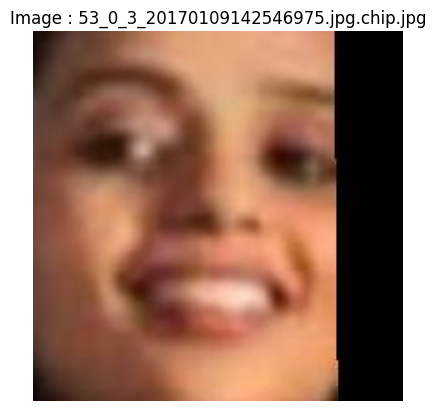

In [2]:
import cv2
import matplotlib.pyplot as plt

# Vérifier qu'on a des images avant d'afficher
if len(image_paths) > 0:
    sample_image_path = image_paths[0]  # Prendre la première image

    # Charger l'image avec OpenCV
    image = cv2.imread(sample_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir en RGB

    # Afficher l'image
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Image : {os.path.basename(sample_image_path)}")
    plt.show()
else:
    print("❌ Aucune image trouvée dans le dossier ! Vérifie le chemin.")


# Charger les Images et les Âges depuis le Dossier avec batches

In [33]:
import os
import cv2
import numpy as np
import gc

# Définir le chemin du dossier contenant les images
image_dir = "/content/UTKFace"

# Fonction générateur pour charger les images progressivement (par lot)
def load_data_generator(image_dir, img_size=(128, 128), batch_size=64):
    file_list = os.listdir(image_dir)

    # Générateur pour charger les données par lots
    batch_images = []
    batch_ages = []

    for img_name in file_list:
        img_path = os.path.join(image_dir, img_name)

        # Charger l'image
        image = cv2.imread(img_path)
        if image is None:
            continue  # Ignore les images corrompues

        # Redimensionner l'image
        image = cv2.resize(image, img_size)
        batch_images.append(image)

        # Extraire l'âge
        try:
            age = int(img_name.split('_')[0])  # L'âge est la première valeur dans le nom
            batch_ages.append(age)
        except ValueError:
            continue  # Ignorer si le nom de fichier ne suit pas le format attendu

        # Lorsque le batch atteint la taille définie, on le renvoie
        if len(batch_images) >= batch_size:
            # Convertir les données du batch en NumPy
            yield (np.array(batch_images, dtype="float32") / 255.0, np.array(batch_ages, dtype="int"))
            batch_images = []  # Réinitialiser le batch
            batch_ages = []

            # Libérer la mémoire utilisée par ce batch
            gc.collect()

    # Si un dernier batch est encore en mémoire (moins que la taille du batch)
    if len(batch_images) > 0:
        yield (np.array(batch_images, dtype="float32") / 255.0, np.array(batch_ages, dtype="int"))
        gc.collect()

# Exemple d'utilisation : Charger les données par lots
batch_size = 64  # Nombre d'images traitées par lot
for batch_images, batch_ages in load_data_generator(image_dir, batch_size=batch_size):
    print(f"Batch avec {len(batch_images)} images")
    # Vous pouvez ensuite utiliser ces données pour entraîner votre modèle


Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64 images
Batch avec 64

# Importer le modele ResNet50 et ajouter une couche de regression pour la prediction de l'age

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# Charger ResNet50 sans les couches supérieures (pour la fine-tuning)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les couches de ResNet50 pour éviter de les modifier pendant le fine-tuning
base_model.trainable = False

# Ajouter des couches personnalisées pour la prédiction de l'âge
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Appliquer un pooling global sur la sortie de ResNet50
    layers.Dense(1024, activation='relu'),  # Couche dense pour apprendre des représentations plus complexes
    layers.Dense(1)  # Prédiction de l'âge (valeur continue)
])

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

# Résumer le modèle pour vérifier sa structure
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Définir le bloc Squeeze-and-Excitation (SE) et creation du model 1

In [28]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Définir le bloc Squeeze-and-Excitation (SE)
def squeeze_excite_block(input_tensor, ratio=16):
    channel_axis = -1  # Dernière dimension (canaux)

    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, input_tensor.shape[channel_axis]))(se)

    # Excitation: Couche Fully Connected (avec ReLU et Sigmoid)
    se = layers.Dense(input_tensor.shape[channel_axis] // ratio, activation='relu')(se)
    se = layers.Dense(input_tensor.shape[channel_axis], activation='sigmoid')(se)

    # Scale les activations du canal
    x = layers.Multiply()([input_tensor, se])
    return x

# Charger ResNet50 sans les couches supérieures (pour fine-tuning)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les couches de ResNet50 pour éviter de les modifier pendant le fine-tuning
base_model.trainable = False

# Ajouter des couches personnalisées pour la prédiction de l'âge
x = base_model.output
x = squeeze_excite_block(x)  # Appliquer le bloc Squeeze-and-Excitation

x = layers.GlobalAveragePooling2D()(x)  # Appliquer un pooling global sur la sortie
x = layers.Dense(1024, activation='relu')(x)  # Couche dense pour affiner la représentation
x = layers.Dense(1)(x)  # Prédiction de l'âge (valeur continue)

# Créer le modèle model1 avec SE
model1 = models.Model(inputs=base_model.input, outputs=x)

# Compiler le modèle model1
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')

# Résumer le modèle pour vérifier sa structure
model1.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,213,377 (100.00 MB)

 Trainable params: 2,625,665 (10.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Train-Test Split


In [29]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import gc

# Supposons que les données sont déjà chargées sous forme de batches
# batch_images et batch_ages contiennent déjà un lot d'images et d'âges

# 🔹 Séparation Train/Test (80% - 20%)
train_images, test_images, train_ages, test_ages = train_test_split(
    batch_images, batch_ages, test_size=0.2, random_state=42
)

# 🔹 Définition des générateurs TensorFlow pour optimiser la mémoire
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_ages)).batch(64).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_ages)).batch(64).prefetch(tf.data.AUTOTUNE)

# Compilation du modele

In [30]:
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='mae', metrics=['mae'])

# Installation de mlflow

In [4]:
pip install mlflow


# Entrainement du modele 1 avec mlflow et l'ajout un fichier logs




In [ ]:
import os
import gc
import mlflow
import mlflow.tensorflow
from tensorflow.keras.callbacks import TensorBoard

# 🔹 Définition des chemins pour les logs
log_dir = "/content/logs"
os.makedirs(log_dir, exist_ok=True)

# 🔹 Configuration de TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# 🔹 Récupération de la batch_size depuis le dataset
batch_size = 64

# 🔹 Intégration de MLflow
mlflow.set_tracking_uri("file:///content/mlruns")  # Stocker les logs localement
mlflow.set_experiment("Age_Prediction_UTKFace")    # Nom de l'expérience

with mlflow.start_run():
    # 🔹 Log des hyperparamètres
    mlflow.log_param("epochs", 20)
    mlflow.log_param("batch_size", batch_size)

    # 🔹 Entraînement du modèle avec TensorBoard
    history_model1 = model1.fit(
        train_dataset,
        epochs=20,
        validation_data=test_dataset,
        callbacks=[tensorboard_callback]
    )

    # 🔹 Log des métriques finales sur MLflow
    final_val_loss = history_model1.history['val_loss'][-1]
    final_val_acc = history_model1.history.get('val_mae', [-1])[-1]  # Sécurisé avec .get()

    mlflow.log_metric("final_val_loss", final_val_loss)
    mlflow.log_metric("final_val_mae", final_val_acc)

    # 🔹 Sauvegarde du modèle avec MLflow
    mlflow.tensorflow.log_model(model1, "saved_model")

# 🔹 Libérer la mémoire après l'entraînement
gc.collect()

print("Entraînement terminé avec suivi sur TensorBoard et MLflow !")


Ici j'ai deja entraine le modele et j'ai sauvegarde avec MLFlow , juste que j'ai supprime l'output par faute


# Deplacer les logs vers mon drive

In [18]:
import os

# Définir le chemin de destination sur Google Drive pour les logs
log_dir_drive = "/content/drive/MyDrive/colab_data/logs_ResNet50"
mlruns_dir_drive = "/content/drive/MyDrive/colab_data/mlruns_ResNet50"

# Créer les répertoires s'ils n'existent pas
os.makedirs(log_dir_drive, exist_ok=True)
os.makedirs(mlruns_dir_drive, exist_ok=True)

# Copier les logs TensorBoard et MLflow vers Google Drive
!cp -r /content/logs/* $log_dir_drive
!cp -r /content/mlruns/* $mlruns_dir_drive

print("✅ Logs et MLflow transférés vers Google Drive avec succès !")


✅ Logs et MLflow transférés vers Google Drive avec succès !


# **Définition du modèle EfficientNetB0

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnet_b0(input_shape=(128, 128, 3)):
    # Charger EfficientNetB0 pré-entraîné sans la couche de classification (include_top=False)
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

    # Geler les poids du modèle de base (si tu veux fine-tuner, tu peux décommenter cette ligne)
    base_model.trainable = False

    # Ajouter des couches supplémentaires pour la régression
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='linear')  # Activation linéaire pour la régression (prédiction continue)
    ])

    # Compiler le modèle avec une fonction de perte pour la régression (MAE ou MSE)
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])  # On peut aussi utiliser 'mse' comme loss

    return model



# **Initialiser le modèle**

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
# Exemple d'utilisation
model3 = build_efficientnet_b0(input_shape=(128, 128, 3))
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 4, 4, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Entrainement du modele 2 avec mlflow et l'ajout un fichier logs




In [11]:
import os
import mlflow
import mlflow.tensorflow
import gc
from tensorflow.keras.callbacks import TensorBoard

# Définir les chemins pour les logs et MLflow
log_dir = "/content/logs3"
mlruns_dir = "/content/mlruns3"

# Créer les répertoires si non existants
os.makedirs(log_dir, exist_ok=True)
os.makedirs(mlruns_dir, exist_ok=True)

# Configuration de TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Définir les datasets d'entraînement et de test
# Assurez-vous que 'train_dataset' et 'test_dataset' sont des objets TensorFlow Dataset valides
# train_dataset = ...  # Chargez ou préparez votre dataset d'entraînement
# test_dataset = ...   # Chargez ou préparez votre dataset de test

# Configuration de MLflow
mlflow.set_tracking_uri("file://" + mlruns_dir)  # Stockage local des logs
mlflow.set_experiment("Age_Prediction_UTKFace_Experiment")  # Nom de l'expérience

# Démarrer un run MLflow
with mlflow.start_run():
    # Log des hyperparamètres
    mlflow.log_param("epochs", 30)
    mlflow.log_param("batch_size", 32)  # Exemple de batch size, ajustez si nécessaire

    # Entraînement du modèle avec TensorBoard
    history_model3 = model3.fit(
        train_dataset,
        epochs=30,
        validation_data=test_dataset,
        callbacks=[tensorboard_callback]
    )

    # Log des métriques finales sur MLflow
    final_val_loss = history_model3.history['val_loss'][-1]
    final_val_mae = history_model3.history.get('val_mae', [-1])[-1]  # Sécurisé avec .get()

    mlflow.log_metric("final_val_loss", final_val_loss)
    mlflow.log_metric("final_val_mae", final_val_mae)

    # Sauvegarde du modèle avec MLflow
    mlflow.tensorflow.log_model(model3, "saved_model")

# Libérer la mémoire après l'entraînement
gc.collect()

print("Entraînement terminé avec suivi sur TensorBoard et MLflow !")


2025/02/08 18:59:33 INFO mlflow.tracking.fluent: Experiment with name 'Age_Prediction_UTKFace_Experiment' does not exist. Creating a new experiment.


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 30.2293 - mae: 30.2293 - val_loss: 20.1945 - val_mae: 20.1945
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 17.8355 - mae: 17.8355 - val_loss: 16.0974 - val_mae: 16.0974
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 15.5343 - mae: 15.5343 - val_loss: 15.9637 - val_mae: 15.9637
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 15.6707 - mae: 15.6707 - val_loss: 15.5862 - val_mae: 15.5862
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 15.3651 - mae: 15.3651 - val_loss: 15.6888 - val_mae: 15.6888
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 14.9551 - mae: 14.9551 - val_loss: 15.9060 - val_mae: 15.9060
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 15.3012 - mae: 15.3012 - val_loss: 15.6791 - val_mae: 15.6791
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 15.0228 - mae: 15.0228 - val_loss: 15.7877 - val_mae: 15.7877
Epoch 9/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 25

2025/02/08 19:13:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/02/08 19:13:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Entraînement terminé avec suivi sur TensorBoard et MLflow !


# Deplacer les logs vers mon drive

In [12]:
import os

# Définir le chemin de destination sur Google Drive pour les logs
log_dir_drive = "/content/drive/MyDrive/colab_data/logs_EfficientNetB0"
mlruns_dir_drive = "/content/drive/MyDrive/colab_data/mlruns_EfficientNetB0"

# Créer les répertoires s'ils n'existent pas
os.makedirs(log_dir_drive, exist_ok=True)
os.makedirs(mlruns_dir_drive, exist_ok=True)

# Copier les logs TensorBoard et MLflow vers Google Drive
!cp -r /content/logs3/* $log_dir_drive
!cp -r /content/mlruns3/* $mlruns_dir_drive

print("✅ Logs et MLflow transférés vers Google Drive avec succès !")


✅ Logs et MLflow transférés vers Google Drive avec succès !


# Tester le model 2

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


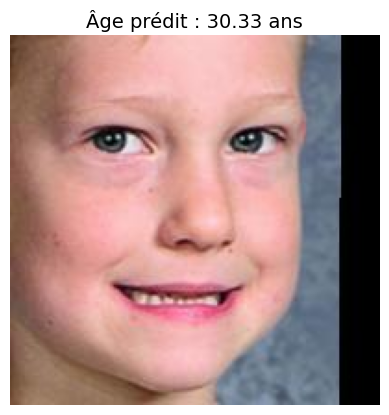

In [20]:
# 📌 Définir la taille d'entrée en fonction du modèle (EfficientNetB0: 224x224, EfficientNetB7: 600x600)
IMG_SIZE = 128  # 600 si tu utilises EfficientNetB0

# 📌 Fonction pour charger et prétraiter une image
def preprocess_image(image_path, img_size=IMG_SIZE):
    # Charger l'image avec OpenCV
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir BGR → RGB
    img = cv2.resize(img, (img_size, img_size))  # Redimensionner l'image
    img = img / 255.0  # Normalisation (valeurs entre 0 et 1)
    img = np.expand_dims(img, axis=0)  # Ajouter une dimension batch (1, img_size, img_size, 3)
    return img

# 📌 Charger une image et la préparer
image_path = "/content/UTKFace/10_0_0_20170103200522151.jpg.chip.jpg"  # Remplace par le chemin de ton image
input_image = preprocess_image(image_path)

# 📌 Faire la prédiction
predicted_age =  model3.predict(input_image)[0][0]  # Extraire la valeur prédite

# 📌 Afficher l'image et la prédiction
plt.imshow(cv2.imread(image_path)[:, :, ::-1])  # OpenCV charge en BGR, inversion vers RGB
plt.axis("off")
plt.title(f"Âge prédit : {predicted_age:.2f} ans", fontsize=14)
plt.show()